Epoch 1/30 ➤ Loss: 5.4502
Epoch 2/30 ➤ Loss: 5.3698
Epoch 3/30 ➤ Loss: 5.3382
Epoch 4/30 ➤ Loss: 5.3177
Epoch 5/30 ➤ Loss: 5.3049
Epoch 6/30 ➤ Loss: 5.2958
Epoch 7/30 ➤ Loss: 5.2842
Epoch 8/30 ➤ Loss: 5.2792
Epoch 9/30 ➤ Loss: 5.2654
Epoch 10/30 ➤ Loss: 5.2651
Epoch 11/30 ➤ Loss: 5.2551
Epoch 12/30 ➤ Loss: 5.2534
Epoch 13/30 ➤ Loss: 5.2456
Epoch 14/30 ➤ Loss: 5.2433
Epoch 15/30 ➤ Loss: 5.2386
Epoch 16/30 ➤ Loss: 5.2320
Epoch 17/30 ➤ Loss: 5.2248
Epoch 18/30 ➤ Loss: 5.2222
Epoch 19/30 ➤ Loss: 5.2231
Epoch 20/30 ➤ Loss: 5.2174
Epoch 21/30 ➤ Loss: 5.2212
Epoch 22/30 ➤ Loss: 5.2180
Epoch 23/30 ➤ Loss: 5.2109
Epoch 24/30 ➤ Loss: 5.2110
Epoch 25/30 ➤ Loss: 5.2097
Epoch 26/30 ➤ Loss: 5.2083
Epoch 27/30 ➤ Loss: 5.2089
Epoch 28/30 ➤ Loss: 5.2085
Epoch 29/30 ➤ Loss: 5.2099
Epoch 30/30 ➤ Loss: 5.2095
✅ Train Ratio 10% ➤ Accuracy: 0.9081
✅ Train Ratio 20% ➤ Accuracy: 0.9127
✅ Train Ratio 30% ➤ Accuracy: 0.9154
✅ Train Ratio 40% ➤ Accuracy: 0.9175
✅ Train Ratio 50% ➤ Accuracy: 0.9197
✅ Train Ratio 

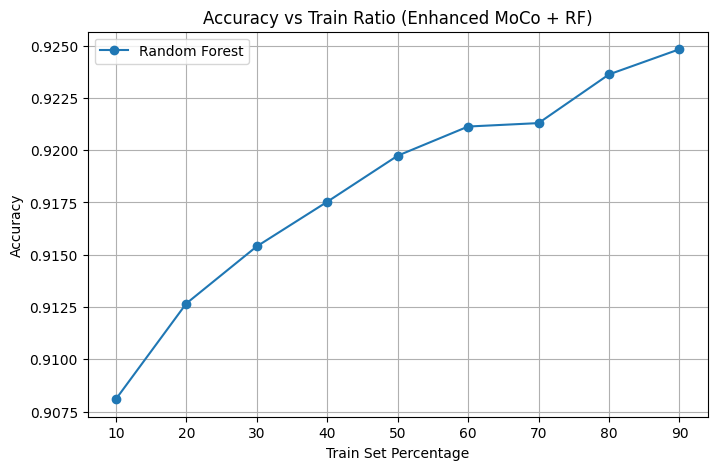

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# === Step 1: Load & preprocess UNSW-NB15 ===
train_df = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test_df = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train_df, test_df], ignore_index=True)
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')
df['label'] = LabelEncoder().fit_transform(df['label'])

X = pd.get_dummies(df.drop(columns=['label']))
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# === Step 2: Advanced augmentations ===
def augment(x, drop_prob=0.1, noise_std=0.02, shuffle_frac=0.1):
    x = x.clone()
    # Random feature dropout
    mask = torch.rand_like(x) > drop_prob
    x = x * mask.float()
    # Add Gaussian noise
    x += torch.randn_like(x) * noise_std
    # Permute some features
    n_shuffle = int(shuffle_frac * x.shape[1])
    if n_shuffle > 0:
        idxs = torch.randperm(x.shape[1])[:n_shuffle]
        for i in idxs:
            x[:, i] = x[torch.randperm(x.shape[0]), i]
    return x

# === Step 3: Enhanced Encoder ===
class DeepEncoder(nn.Module):
    def __init__(self, input_dim, proj_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, proj_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# === Step 4: NT-Xent loss ===
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = nn.functional.normalize(z1, dim=1)
    z2 = nn.functional.normalize(z2, dim=1)
    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)  # (2N, D)
    sim = torch.matmul(z, z.T) / temperature
    mask = torch.eye(2*N, device=z.device).bool()
    sim.masked_fill_(mask, -1e9)

    labels = torch.arange(N, device=z.device)
    labels = torch.cat([labels + N, labels], dim=0)
    return nn.CrossEntropyLoss()(sim, labels)

# === Step 5: Train Encoder ===
def train_encoder(X_tensor, proj_dim=128, batch_size=512, epochs=30, lr=1e-3):
    model = DeepEncoder(X_tensor.shape[1], proj_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    loader = data_utils.DataLoader(data_utils.TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        losses = []
        for (x,) in loader:
            x1 = augment(x)
            x2 = augment(x)
            z1 = model(x1)
            z2 = model(x2)
            loss = nt_xent_loss(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} ➤ Loss: {np.mean(losses):.4f}")
    return model

# === Step 6: Train model and extract features ===
encoder = train_encoder(X_tensor)
encoder.eval()
with torch.no_grad():
    features = encoder(X_tensor).numpy()

# === Step 7: Train RF downstream on varying ratios ===
ratios = list(range(10, 100, 10))
results = []

for ratio in ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        features, y, train_size=ratio/100.0, stratify=y, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=200, max_depth=25, min_samples_leaf=2, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    results.append({'train_ratio': ratio, 'accuracy': acc})
    print(f"✅ Train Ratio {ratio}% ➤ Accuracy: {acc:.4f}")

# === Step 8: Save & Plot ===
results_df = pd.DataFrame(results)
results_df.to_csv("enhanced_moco_rf_results.csv", index=False)

plt.figure(figsize=(8, 5))
plt.plot(results_df['train_ratio'], results_df['accuracy'], marker='o', label="Random Forest")
plt.title("Accuracy vs Train Ratio (Enhanced MoCo + RF)")
plt.xlabel("Train Set Percentage")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.savefig("enhanced_moco_rf_plot.png")
plt.show()
